<a href="https://colab.research.google.com/github/rim-the-optimizer/VRPOD/blob/main/VRPOD_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'VRPOD'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 69 (delta 52), reused 68 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 78.92 KiB | 2.82 MiB/s, done.
Resolving deltas: 100% (52/52), done.
✅ Repository wurde geklont.
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  1200

Optimize a model with 431 rows, 1066 columns and 1859 nonzeros
Model fingerprint: 0x89588ec7
Variable types: 0 continuous, 364 integer (364 binary)
Semi-Variable types: 0 continuous, 702 integer
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [7e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RH

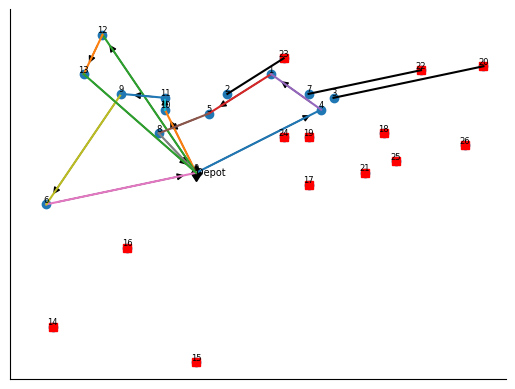

In [5]:
# Repository klonen, falls es noch nicht vorhanden ist
import os

repo_url = "https://github.com/rim-the-optimizer/VRPOD.git"
repo_name = "VRPOD"

if not os.path.exists(repo_name):
    !git clone {repo_url}
    print("✅ Repository wurde geklont.")
else:
    print("✅ Repository existiert bereits.")

# In den Repository-Ordner wechseln
os.chdir(repo_name)

!pip install matplotlib
!pip install gurobipy
!pip install networkx


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum
import random as rd
import math as mt



"""                         Params to be set
"""

zeta=1.1 # detour that the driver would take
ODs=13 # amount of ODs |K|
rho=0.2 # compensation rate


"""
                           Create Data Modell

"""
#paths of solomon instances

data_folder = os.path.join(os.getcwd(), "data")

C101 = os.path.join(data_folder, "c101.txt")
C201= os.path.join(data_folder, "c201 - Kopie.txt")
R101= os.path.join(data_folder, "r101.txt")
R201= os.path.join(data_folder, "r201.txt")
RC101= os.path.join(data_folder, "rc101.txt")
RC201= os.path.join(data_folder, "rc201.txt")
#startrow accoarding to file
start_row=10 #exclusing depot
start_row0=9 # depot inclusive
start_rowQ=4 # for capacity Q
#Depot number
depot=[0]


"""List C Customers """
#extract customer list from solomon instance - choose which instance should be used C101...
def create_listC(C201, start_row):
    with open(C201, 'r') as f:
        Daten = [line.strip().split() for line in f]
        global C
        C = list()
        for i, line in enumerate(Daten):
            if i >= start_row:
                C.append(int(line[0]))
create_listC(C201, start_row)
# List of Customer nodes and depot
Neu = depot + C


"""List X and Y Coordinates from Solomon instance including Depot"""
#extract coordinates list from solomon instance - choose which instance should be used C101...
def create_listNX(C201, start_row0):
    with open(C201, 'r') as f:
        Daten = [line.strip().split() for line in f]
        global NX
        NX = list()
        for i, line in enumerate(Daten):
            if i >= start_row0:
                NX.append(int(line[1]))
        global NY
        NY = list()
        for i, line in enumerate(Daten):
            if i >= start_row0:
                NY.append(int(line[2]))
        global dips
        dips = list()
        for i, line in enumerate(Daten):
            if i >= start_row0:
                dips.append(int(line[3]))
create_listNX(C201, start_row0)


"""convert d1 to a dict"""
Cips=C.copy()
Cips.insert(0,0)
d1={node: demand for node, demand in zip(Cips,dips)}



"""List K of ODs and coordinates of ODs destinations"""
#ODs=int(mt.ceil(len(C)/3)) # amount of ODs |K|
k=ODs+len(C)
#list of ODs
K=[i for i in range(len(C)+1,k+1)]
#amount of ODs in lower left corner
k1=ODs-10
#amount of ODs in upper right corner
k2=ODs-k1
XK1=np.random.randint(1,45,k1) #xcoord lower left
XK1=XK1.tolist()
YK1=np.random.randint(1,45,k1) #ycoord lower left
YK1=YK1.tolist()
XK2=np.random.randint(45,90,k2) #xcoord upper right
XK2=XK2.tolist()
YK2=np.random.randint(45,90,k2) # ycoord upper right
YK2=YK2.tolist()
""" List and coordinates of all nodes N"""
N = depot + C + K
NXcopy=NX.copy()
NXcopy.extend(XK1)
NXcopy.extend(XK2)
NYcopy=NY.copy()
NYcopy.extend(YK1)
NYcopy.extend(YK2)

""" List of arcs """
A=[(i,j) for i in N for j in N if i!=j] # all arcs
Ab=[(i,j) for i in C for j in K if i!=j] # arcs from customers to OD'S destinations
Arr=[(i,j) for i in Neu for j in Neu if i!=j] # Arcs from depot&customers to depot&customers without K

""" distances and prices and demand of ODs Destinations """
di={(i,j):np.hypot(NXcopy[j]-NXcopy[i],NYcopy[j]-NYcopy[i])for i,j in A} #distance
mile=0.3 #price per km
c={(i,j):(di[i,j]*mile) for i,j in A} #costs
d2={(i):rd.randint(1,4)*10 for i in K} #demand of ODs destinations
d=d1.copy() #updating dict of all demands
d.update(d2)

beta1={(i,k):1 for i in C for k in K if di[0,i] + di[i,k]<= zeta*di[0,k]} #allowed detour
beta2={(i,k):0 for i in C for k in K if di[0,i] + di[i,k] > zeta*di[0,k] } #detour not allowed
beta=beta1.copy()
beta.update(beta2) #customer can be served by OD
COD={(i,j) for i in C for j in K if beta[i,j]>0.99} # set of OD Customers (Ck) which the ODs are willing to serve wrt to the Destinations
p=[0]+[rho*c[0,i] for i in C]

""" capacities """
def create_Q(C201, start_rowQ):
    with open(C201, 'r') as f:
        Daten = [line.strip().split() for line in f]
        global Q
        Q = list
        for i, line in enumerate(Daten):
            if i >= start_rowQ:
                Q=line[1]
                break
create_Q(C201, start_rowQ)


"""                          plot data as scatter
"""


fig, ax =plt.subplots()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.scatter(NXcopy,NYcopy)
plt.xticks(np.arange(0,90,5))
plt.yticks(np.arange(0,90,5))

plt.plot(NX[0],NY[0], markersize=8,marker='d', color='k') # depot plot

for i in range(len(NYcopy)):
    ax.text(x=NXcopy[i],y=NYcopy[i],s=i,verticalalignment='bottom',horizontalalignment='center', size=6 )

ax.text(x=NX[0],y=NY[0], s='Depot', horizontalalignment='left', verticalalignment='center', size=7)

for i in K:
    plt.plot(NXcopy[i],NYcopy[i], markersize=6,marker='s', color='r')



"""                          create the VRPOD model
"""


m=gp.Model()
z=m.addVars(C, vtype=GRB.BINARY, name="z")
y=m.addVars(A, vtype=GRB.SEMIINT, lb=0, name="y")
x=m.addVars(Arr,vtype=GRB.BINARY, name="x")
omega={}
for k in K:
    for i in C:
        omega[i,k]=m.addVar(vtype=GRB.BINARY,name='omega')


m.setObjective(quicksum(c[i,j]*x[i,j] for i,j in Arr)+quicksum(p[i]*quicksum(omega[i,k]for k in K) for i in C),gp.GRB.MINIMIZE)

NB1=m.addConstrs((quicksum(x[i,j] for j in Neu if i!=j) == quicksum(x[j,i] for j in Neu if i!=j ) for i in C), name='NB1')
NB2=m.addConstr(((quicksum(x[i,j] for i,j in Arr if i==0) == quicksum(x[j,i] for j,i in Arr if i==0))  ), name='NB2')
NB3=m.addConstrs((quicksum(x[i,j] for j in Neu if i!=j) ==z[i] for i in C), name='NB3')
NB4=m.addConstrs((quicksum(y[j,i] for j in Neu if i!=j) - quicksum(y[i,j] for j in Neu if i!=j)== d[i]*z[i] for i in C), name='NB4')
NB5=m.addConstr((quicksum(y[j,i] for j,i in A if i==0) - quicksum(y[i,j]for i,j in A if i==0) == quicksum(-d[i]*z[i] for i in C ) ), name='NB5')
NB6=m.addConstrs((y[i,j] <= Q*x[i,j] for i,j in Arr), name='NB6')
NB7=m.addConstrs((y[i,0] == 0 for i in C), name='NB7')
NB9=m.addConstrs((quicksum(omega[i,k]for k in K) +z[i]==1 for i in C), name='NB9')
NB10=m.addConstrs((omega[i,k]<=beta[i,k] for i in C for k in K), name='NB10')

NB11=m.addConstrs((quicksum(omega[i,k] for i in C)<=1 for k in K), name='NB11')


""" set computing time and optimize"""
m.setParam('TimeLimit',20*60)
m.optimize()


""" extract results """
Ergebnis=m.ObjVal
print("Der ZFW(Kosten der gewählten Touren): ",Ergebnis)
m.write('neu.lp')
#print("set of OD Customers (Ck) which the ODs are willing to serve wrt to the Destinations: ", COD, ".")

""" plot result """
active_arcs=[a for a in Arr if x[a].x>0.99]
C_k=[a for a in Ab if omega[a].X>0.99]
Oi=np.zeros(len(C_k))
oha=Oi.tolist()
O1=C_k.copy()
for i in O1:
    list(i)
    [i].insert(0,0)

O=np.transpose(O1)

for i,j in active_arcs:
    plt.plot([NXcopy[i],NXcopy[j]],[NYcopy[i],NYcopy[j]])

import networkx as nx
G=nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(active_arcs)
pos=nx.spring_layout(G)

for i in range(len(pos)):
    pos[i]=(NXcopy[i],NYcopy[i])

nx.draw_networkx_edges(G, pos, edgelist=active_arcs, arrows=True)
for v,w in O1:
    plt.plot([NXcopy[v],NXcopy[w]],[NYcopy[v],NYcopy[w]],color='black')

#nx.draw_networkx_edges(G, pos, edgelist=O, arrows=True)
""" further results """

Startkantenx=[(i,j) for i,j in active_arcs if i==0]
routes=len(Startkantenx)
print('Routes= ', routes)
RDcost=sum(c[i,j]*x[i,j].x for i,j in Arr)
ODcosti=Ergebnis-RDcost
ODcost=ODcosti/Ergebnis*100
print('OD costs in%= ', ODcost)
ODs=len(C_k)
print('ODs used:',ODs)

print("Kosten regular driver: ",RDcost)
print("Kosten OD:", ODcosti)

r=[]                               # Liste der Touren
for o in Startkantenx:
    r.append([o])

Anzahl_Kanten=len(active_arcs)
import itertools
while sum(len(x) for x in r)< Anzahl_Kanten :
    for u in range(len(r)):
        for (i,j),(k,l) in itertools.product(active_arcs,active_arcs):
            if (i,j)==r[u][-1] and j!=0:
                if j==k:
                    r[u].append((k,l))

print("Die Touren lauten:",r)
